In [1]:
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from functions import *

from tqdm import tqdm

Using cupy


In [2]:
@dataclass
class Config:
    nx: int = 400
    ny: int = 200
    steps: int = 10000
    output_stride: int = 500
    molecular_weights: tuple[float, float, float] = (28.0, 2.0, 44.0)  # N2, H2, CO2
    # Left half: 50% N2 + 50% H2, Right half: 50% N2 + 50% CO2
    left_frac: tuple[float, float, float] = (0.5, 0.25, 0.35) # pressure fraction
    right_frac: tuple[float, float, float] = (0.5, 0.35, 0.25)
    total_pressure: float = 1.0
    theta: float = 0.5
    nB: int = 2
    frames_dir: str = "demo_frames/three_species_mixing"

In [3]:
def initialise_chamber(config: Config):
    nx, ny = config.nx, config.ny
    species = 3
    phi = 1.0 / xp.array(config.molecular_weights, dtype=xp.float64)

    # Partial pressures for each species
    psigma = xp.zeros((species, nx, ny), dtype=xp.float64)
    mid = nx // 2
    left = xp.array(config.left_frac, dtype=xp.float64) * config.total_pressure
    right = xp.array(config.right_frac, dtype=xp.float64) * config.total_pressure
    for s in range(species):
        psigma[s, :mid, :] = left[s]
        psigma[s, mid:, :] = right[s]

    # Convert partial pressures to densities: p_s = phi_s * rho_s / 3
    rho_s = xp.zeros_like(psigma)
    for s in range(species):
        rho_s[s] = 3.0 * psigma[s] / phi[s]

    # Initial populations from equilibrium with zero velocity
    f = xp.zeros((species, 9, nx, ny), dtype=xp.float64)
    ux_s = xp.zeros((species, nx, ny), dtype=xp.float64)
    uy_s = xp.zeros((species, nx, ny), dtype=xp.float64)
    feq = equilibrium(f, rho_s, phi, ux_s, uy_s)
    f[...] = feq
    return f, phi

In [4]:
def main(absorption_coefficient, non_absorb_mask):
    cfg = Config()
    out_dir = 'demo_frames'

    f, phi = initialise_chamber(cfg)
    molecular_weights = xp.array(cfg.molecular_weights, dtype=xp.float64)

    for step in tqdm(range(cfg.steps + 1)):
        if step % cfg.output_stride == 0:
            save_concentration_frames(f, phi, step, molecular_weights)
        if step == cfg.steps:
            break
        f = bgk_step(f, molecular_weights, phi, cfg.nB, lattice_stream_BC_full, step, absorption_coefficient, non_absorb_mask)

    print(f"Saved frames to {out_dir}")

    return f

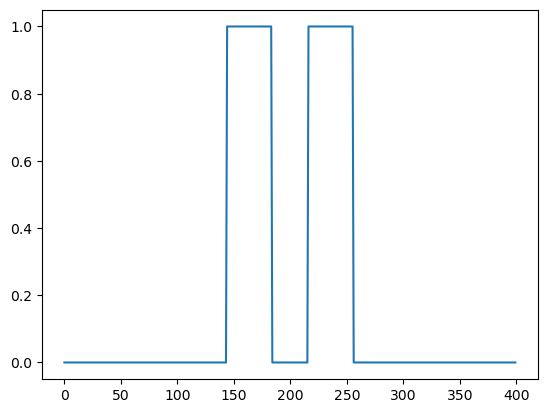

In [25]:
absorption_coefficient = 100

non_absorb_mask = xp.zeros(Config.nx, dtype=bool)
gap = 32
width = 40
non_absorb_mask[Config.nx//2 - gap//2 - width: Config.nx//2- gap//2] = True
non_absorb_mask[Config.nx//2 + gap//2 : Config.nx//2 + gap//2 + width] = True

plt.plot(to_numpy(non_absorb_mask))

In [26]:
#%prun -D mslbm.pstat f = main()
f = main(absorption_coefficient, non_absorb_mask)

100%|█████████▉| 10000/10001 [04:12<00:00, 39.56it/s]

Saved frames to demo_frames


In [7]:
def slope_absorption(f):
    phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
    rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)

    plt.plot(to_numpy(rho_s[0, 125, :]))

    fit_steps = 5
    slope, b = np.polyfit(np.arange(fit_steps), to_numpy(rho_s[0, 125, :fit_steps]), 1)
    print(f"Slope: {slope}")
    plt.plot(np.arange(fit_steps), np.arange(fit_steps) * slope + b)

    return slope, b


In [7]:
from joblib import Parallel, delayed

def _single_run(absorption_rate):
    f = main(1/absorption_rate)
    slope, b = slope_absorption(f)
    return slope, b

def parameter_sweep_parallel(num, n_jobs=2, backend="loky"):
    a = np.linspace(-4, 1, num = num, endpoint = True)
    absorption_rates = np.power(10, a)

    results = Parallel(n_jobs=n_jobs, backend=backend)(
        delayed(_single_run)(absorption_rate)
        for absorption_rate in absorption_rates
    )

    slopes, Cws = zip(*results)
    return absorption_rates, np.array(slopes), np.array(Cws)

def parameter_sweep(num):
    a = np.linspace(-4, 1, num = num, endpoint = True)
    absorption_rates = np.power(10, a)

    slopes = []
    Cws = []

    for i in range(len(a)):
        f = main(1/absorption_rates[i])
        slope, b = slope_absorption(f)
        slopes.append(slope)
        Cws.append(b)

    return absorption_rates, np.array(slopes), np.array(Cws)


In [8]:
absorption_rates, slopes, Cws = parameter_sweep_parallel(num = 30, n_jobs=3, backend="loky")

KeyboardInterrupt: 

no parallel: 21m18s

n_job = 2 : 17m53s

n_job = 3 : 12m43s

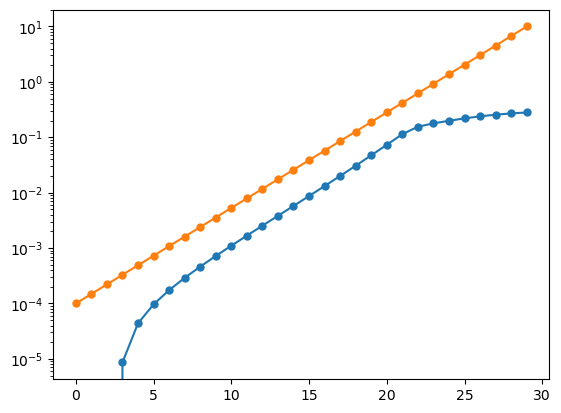

In [8]:
absorption_measured = slopes/Cws
plt.plot(absorption_measured, marker="o", markersize=5)
plt.plot(absorption_rates, marker="o", markersize=5)
plt.yscale('log')
plt.show()

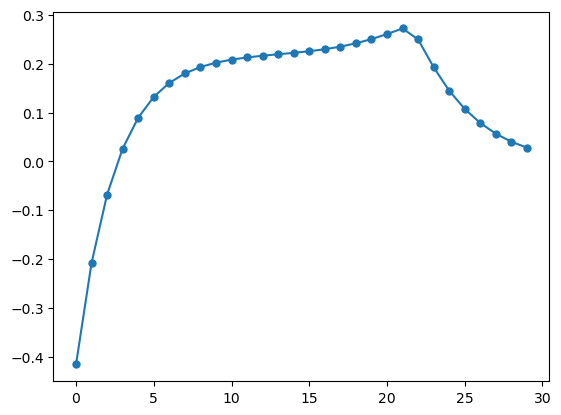

In [9]:
plt.plot(absorption_measured/absorption_rates, marker="o", markersize=5)
#plt.yscale('log')

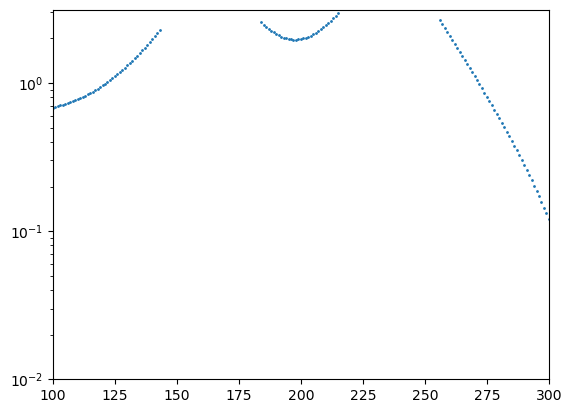

In [27]:
def plot_boundary_concentration():

    phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
    rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)

    concentration_profile = to_numpy(rho_s[0, :, 0])
    base_concentration = np.min(concentration_profile)
    extra_thickness = concentration_profile - base_concentration

    plt.scatter(np.arange(f.shape[2])[to_numpy(non_absorb_mask) == 0], extra_thickness[to_numpy(non_absorb_mask) == 0], s = 1)
    plt.xlim(0, f.shape[2])
    plt.xlim(100, 300)
    plt.ylim(bottom = 1e-2)
    plt.yscale('log')

    '''
    plt.scatter(np.arange(f.shape[2])[to_numpy(non_absorb_mask) == 0], to_numpy(rho_s[0, :, 0])[to_numpy(non_absorb_mask) == 0], s = 1)
    plt.xlim(0, f.shape[2])
    #plt.xlim(100, 300)
    plt.ylim(bottom = 0)
    '''


    return

plot_boundary_concentration()